# Simulating a classical wave through a varying refractive index
In this notebook we shall aim to form an iterative method to simulate a classical 1 dimensional wave, whos velocity will vary based on its position in the simulated medium.
The equation for our wave takes the form:
$$\frac{\partial^2\theta}{\partial t^2}=c(x)^2\frac{\partial^2\theta}{\partial x^2}$$
The function $c(x)$ represents the velocity of the wave, and can be represented as 
$$c(x)=\frac{c}{n(x)}$$
With $n(x)$ being the refractive index.
To solve this equation over time, we use an iterative approach. This approach is formed by taking the centred difference formula for both of the second order partial derivatives, and rearranging:
$$\frac{\theta_{x,t+1}-2\theta_{x,t}+\theta_{x,t-1}}{\Delta t^2}=c(x)^2\frac{\theta_{x+1,t}-2\theta_{x,t}+\theta_{x-1,t}}{\Delta x^2}$$
$$r(x)=c(x)\frac{\Delta t}{\Delta x}$$
$$\theta_{x,t+1}=2(1-r(x)^2)\theta_{x,t}-\theta_{x,t-1}+r(x)^2[\theta_{x+1,n}-\theta_{x-1,t}]$$
To find the value $\theta_{x,t+1}$ we require the wave at the previous 2 time steps, as well as at the previous and next position steps. Our function shall take the two previous time steps as an argument, and find the two position steps by rolling the wave function at the time step $t$. We must also pass an array of the values r as a function of position.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def UpdateWave1D(theta_n, theta_nm1, r):
    """
    Calculates the value of theta at the next time step based on the 
    previous two time steps
    Inputs:
        theta_n: array like, The wave at the previous time step
        theta_nm1: array like, the wave from two time steps previous
        r: constant/array like, the value of r at the given position of the wave
    Outputs:
        theta_np1: The wave at the next time step.
    """
    theta_ip1 = np.roll(theta_n, 1)
    theta_im1 = np.roll(theta_n,-1)
    theta_np1 = 2*(1-r**2)*theta_n - theta_nm1 + r**2 * (theta_ip1 + theta_im1)
    return theta_np1


Now that we have created our update function, we can plot the progression of the wave over time. Below we do this in two different ways.
The first method is to create a 3 dimensional surface plot, where the x axis represents the displacement of the wave, the y axis represents the time progression, and the z axis the value of the $\psi(x,t)$.
We shall initiate our wave to exist over only 1 wave length, which will help make the time progression of the wave clearer.

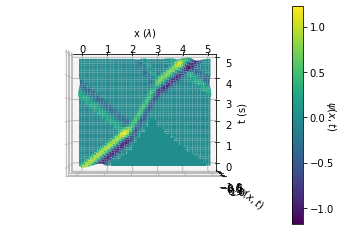

In [4]:

#Initiate wave values
freq = 1 #Hz
wlength = 1 #m
velocity = freq*wlength #m s^-1
ang_freq = freq * 2*np.pi # rad/s
k = 2*np.pi/wlength #Wave vector

N = 50 #Number of points per wavelength
Length = 5 #Size of system in wave lengths

#Initiate other values
dx = wlength/N
r = np.full((Length*N), 0.3)
#r = np.ones(Length*N)*0.3
r[2*N:3*N]=0.15
#Constant dt based on initial r
dt = r[0]*dx/velocity 
waveX = np.arange(0, Length*wlength, dx)

#Create first two time steps 
theta_0 = np.sin(k*waveX - ang_freq * 0)
theta_t = np.sin(k*waveX - ang_freq*dt)
theta_0[N:]=0
theta_t[N+1:]=0
time = [0, dt]
timeSolutions = [theta_0, theta_t]

total_time_steps = 800

for i in range(0, total_time_steps):
    #Find wave_(n+1) based on wave_(n) and wave_(n-1)
    theta_n = UpdateWave1D(theta_t, theta_0, r)
    #Set new values
    theta_0 = theta_t
    theta_t = theta_n
    #Store solution at time t
    timeSolutions.append(theta_n)
    #Append time array, ensures time array has same size as timeSolutions
    time.append(time[-1] + dt)

#Create required 2d numpy arrays
timeSolutions = np.array(timeSolutions)
x2d,t2d = np.meshgrid(waveX, time)

#Create and display 3d surface plot
surf_fig = plt.figure()
surf_ax = surf_fig.add_subplot(111, projection='3d')
surf_ax.set_xlabel(r"x ($\lambda$)")
surf_ax.set_ylabel("t (s)")
surf_ax.set_zlabel(r"$\psi(x,t)$")
surf_ax.view_init(90,270)

surf = surf_ax.plot_surface(x2d,t2d, timeSolutions, cmap='viridis')
surf_col = surf_fig.colorbar(surf)
surf_col.ax.set_ylabel(r"$\psi(x,t)$", rotation=270)

plt.show()

In the above plot, we can look at the bottom left corner (0<=x<=1, t=0) to see the initial wave. The progression runs along the t axis. We see the wave travel with its shape remaining the same, until it reaches the point $x=2\lambda$. At this point we change the value of r by a factor of a half. At this point, the wave splits in two, with a fraction 'reflecting' back, and some continuing onwards. We can also see a change in velocity of the wave at this boundary, although with the values of r used ($r_0=0.3, r_1=0.15$) this effect isn't hugely clear. 

Another way to display this same information is through a series of 2 dimensional plots, as shown below.

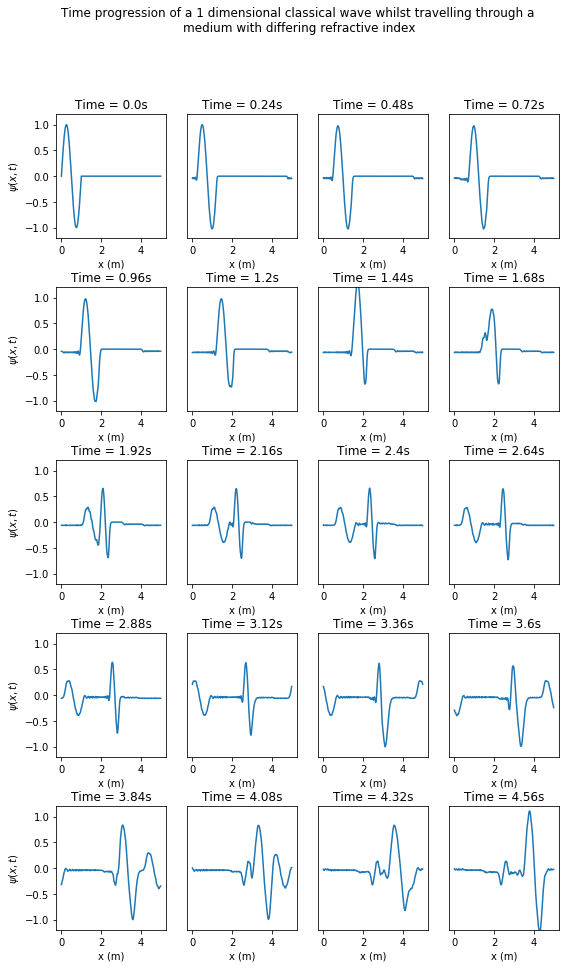

In [26]:
#Create figure
simp_fig = plt.figure(figsize=(9,15))

graph_cur = 0
graph_jump = int(total_time_steps/20)

#Ensure enough whitespace between figures
simp_fig.subplots_adjust(hspace=0.4)

#Plot all 20 figures
for g in range(1, 21):
    ax = simp_fig.add_subplot(5,4,g)
    #print(timeSolutions[graph_cur])
    ax.plot(waveX, timeSolutions[graph_cur])
    ax.set_xlabel("x (m)")
    #Ensure axis all have same y scale to ensure clear results.
    ax.set_ylim(-1.2,1.2)
    #Make axis look good
    if((g-1)%4!=0):
        ax.get_yaxis().set_visible(False)
    else:
        ax.set_ylabel(r"$\psi(x,t)$")
    ax.set_title("Time = " + str(round(graph_cur*dt,2)) + "s")
    graph_cur+=graph_jump
simp_fig.suptitle("Time progression of a 1 dimensional classical wave whilst travelling through a \nmedium with differing refractive index")
plt.show()

This method has advtanges and disadvantages compared to the 3d plot. The first two plots show nothing interesting, simply the progression of the wave before reaching the change in r. In plot 3 however, we see part of the wave suddenly spike in value with part of it decreasing in value. This asymmetry is due to a fraction of the wave being reflected at the boundary and constructivly interfering with the rear of the wave, resulting in a net higher amplitude. This shows one of the strengths of plotting in this style, as this effect isn't as apparent in the 3d plots. 
Care must be taken with this type of plot however. matplotlib automatically scales the y axis of each graph, and so by default from around the 8th plot the y axis has a range of $-0.5\to0.5$. This isn't initially apparent when glancing at the results, and so care must be taken when plotting in this style.
This method of plotting also becomes quite messy for larger values of t, due to the interactions of the various incident and reflected waves. Although the same occurs in the 3d plot, the 3d plot has a clearer overall visual at this larger values of t.
The 3d plot also has the advtange of showing all time steps, rather than a selection.
Next we shall attempt to plot a similar idea, but with a value of r which changes gradually, without a sudden jump:

0.30000000000000004
0.3


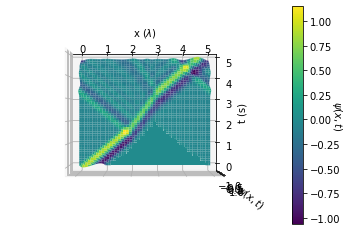

In [27]:
#Create same inital r array
r = np.full((Length*N), 0.3)
#Define 2W<x<3W to have an oscillating value of r
for x in range(2*wlength*N, 3*wlength*N, 1):
    x_ = x*dx
    r[x] =  0.1+0.2*np.abs(np.cos((x-2*N*wlength)/(wlength*N) * 6*np.pi))

    
#Ensure start and end point of region have r=0.3
print(r[2*wlength*N])
print(r[3*wlength*N])

theta_0 = np.sin(k*waveX - ang_freq * 0)
theta_t = np.sin(k*waveX - ang_freq*dt)
theta_0[N:]=0
theta_t[N+1:]=0
time = [0, dt]
timeSolutions_vary = [theta_0, theta_t]

total_time_steps = 800
    
for i in range(0, total_time_steps):
    #Find wave_(n+1) based on wave_(n) and wave_(n-1)
    theta_n = UpdateWave1D(theta_t, theta_0, r)
    #Set new values
    theta_0 = theta_t
    theta_t = theta_n
    #Store solution at time t
    timeSolutions_vary.append(theta_n)
    #Append time array, ensures time array has same size as timeSolutions
    time.append(time[-1] + dt)

#Create required 2d numpy arrays
timeSolutions_vary = np.array(timeSolutions_vary)
x2d,t2d = np.meshgrid(waveX, time)

#Create and display 3d surface plot
surf_fig = plt.figure()
surf_ax = surf_fig.add_subplot(111, projection='3d')
surf_ax.set_xlabel(r"x ($\lambda$)")
surf_ax.set_ylabel("t (s)")
surf_ax.set_zlabel(r"$\psi(x,t)$")
surf_ax.view_init(90,270)

surf = surf_ax.plot_surface(x2d,t2d, timeSolutions_vary, cmap='viridis')
surf_col = surf_fig.colorbar(surf)
surf_col.ax.set_ylabel(r"$\psi(x,t)$", rotation=270)

plt.show()

We have chosen an r that varys with repsect the absolute value of a cosine function. The equation for between $2\lambda \to 3\lambda$ takes the form:
$$r=0.1 + 0.2\times \left|\cos\left(\frac{x-\lambda}{\lambda}\right)\times6\pi\right|$$
This results in a value that of r that oscillates from 0.3 to 0.1 to 0.3 a total of 3 times. We can see the effect of this in the plot.
Although the relative amplitude of relfected waves is small, we can see 6 points between $x=2\lambda \to x=3\lambda$ at which the wave is reflected.
Although it isn't very clear here, the velocity of the wave when reaching the varying medium doesn't have a drastic change in velocity. Instead, we see a slight curve in our surface plot, implying a gradual change in the velocity of propogation of the wave.